In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#import all dependencies
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import os

In [27]:
#set all constants
BATCH_SIZE = 32#each batch will contain maximum of 32 elements
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [4]:
#load images to tensorflow dataset object
dataset=tf.keras.preprocessing.image_dataset_from_directory("/content/gdrive/MyDrive/potato_disease",seed=123,shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


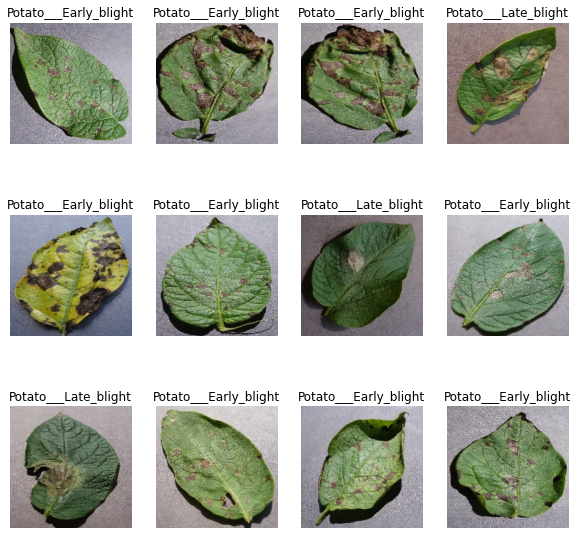

In [8]:
#data visualization
#for 12 images in a batch
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
#splitting dataset
#80%==>train (dataset to be used while training) 10%==>validation (dataset to be tested against while training) 10%==>test (dataset to be tested against after we trained a model)

# train_size=len(dataset)*0.8#54
# train_ds=dataset.take(54)

# left_ds=dataset.skip(54)
# val_ds=left_ds.take(6)
# test_ds=left_ds.skip(6)

# print("train_ds: ",len(train_ds))
# print("val_ds: ",len(val_ds))
# print("test_ds: ",len(test_ds))

train_ds:  54
val_ds:  6
test_ds:  8


In [9]:
#A function defined to split the datasets to train, val and test
def split_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=10000):
  train_size=int(len(dataset)*train_split)
  val_size=int(len(dataset)*val_split)

  train_ds=dataset.take(train_size)
  val_ds=dataset.skip(train_size).take(val_size)
  test_ds=dataset.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds

In [10]:
train_ds,val_ds,test_ds=split_dataset(dataset)

In [11]:
print("train_ds: ",len(train_ds))
print("val_ds: ",len(val_ds))
print("test_ds: ",len(test_ds))

train_ds:  54
val_ds:  6
test_ds:  8


In [12]:
#cache,shuffle and prefetch the dataset
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:

#data preprocessing

resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),#resize to desired size: useful when we need to resize the supplied image if it not our desired size
    layers.experimental.preprocessing.Rescaling(1./255),#normalize each image pixel value
])


##data augmentation

data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])


In [15]:
train_ds=train_ds.map(lambda x,y:(data_augmentation(x,training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
#build convolutional neural network(CNN) model

input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [18]:
#compile the model using adam optimizer

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history=model.fit(train_ds,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1,epochs=EPOCHS,)

Epoch 1/30
54/54 [==============================] - 14s 268ms/step - loss: 0.0882 - accuracy: 0.9664 - val_loss: 0.3875 - val_accuracy: 0.8698
Epoch 2/30
54/54 [==============================] - 13s 241ms/step - loss: 0.0729 - accuracy: 0.9763 - val_loss: 0.1561 - val_accuracy: 0.9427
Epoch 3/30
54/54 [==============================] - 13s 237ms/step - loss: 0.0500 - accuracy: 0.9780 - val_loss: 0.2202 - val_accuracy: 0.9271
Epoch 4/30
54/54 [==============================] - 13s 236ms/step - loss: 0.0441 - accuracy: 0.9855 - val_loss: 0.4610 - val_accuracy: 0.8802
Epoch 5/30
54/54 [==============================] - 13s 235ms/step - loss: 0.0905 - accuracy: 0.9641 - val_loss: 0.3858 - val_accuracy: 0.8750
Epoch 6/30
54/54 [==============================] - 13s 230ms/step - loss: 0.0471 - accuracy: 0.9809 - val_loss: 0.1023 - val_accuracy: 0.9635
Epoch 7/30
54/54 [==============================] - 13s 247ms/step - loss: 0.0477 - accuracy: 0.9826 - val_loss: 0.3183 - val_accuracy: 0.9062

In [29]:
scores=model.evaluate(test_ds)#performance can be increased by increasing the number of epochs

8/8 [==============================] - 0s 25ms/step - loss: 0.1614 - accuracy: 0.9569


In [30]:
scores

[0.16138064861297607, 0.9568965435028076]

In [22]:
#plotting accuracy and loss
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
type(history.history['loss'])

list

In [32]:
len(history.history['loss'])

30

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

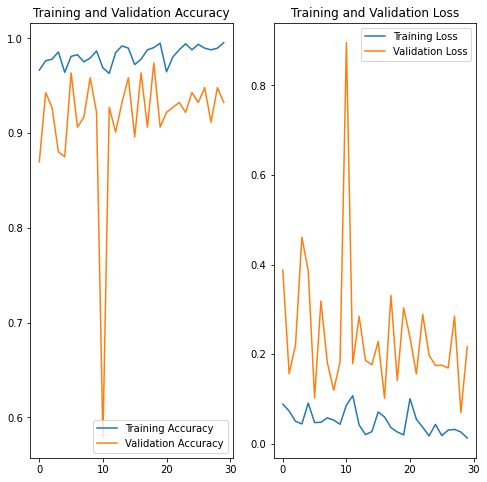

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Image
Actual label: Potato___Early_blight
1/1 [==============================] - 0s 147ms/step
Predicted label: Potato___Early_blight


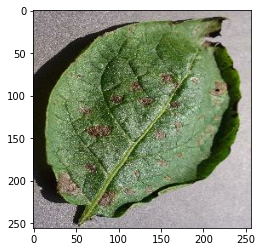

In [37]:
#prediction
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("Image")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
#A function defined for inference
def predict(model, img):
    img_arr = tf.keras.preprocessing.image.img_to_array(img)
    img_arr = tf.expand_dims(img_arr, 0)

    predictions = model.predict(img_arr)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


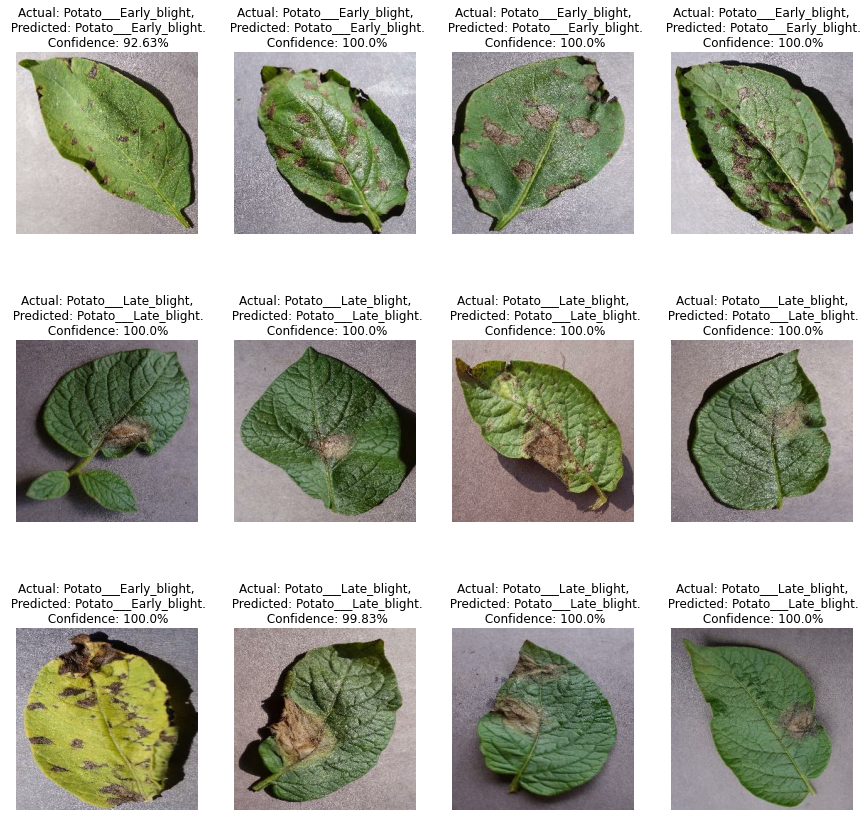

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [40]:
#save the model
#append the model to the list of models as a new version
# model_version=max([int(i) for i in os.listdir("/content/gdrive/MyDrive/models") + [0]])+1
# model.save(f"/content/gdrive/MyDrive/models/{model_version}")
model.save("/content/gdrive/MyDrive/models/potatoes.h5")